<a href="https://colab.research.google.com/github/VincentCsNv/SPARKS/blob/main/Classification_CIFAR/classif_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install torch torchvision --quiet
!pip install sympy==1.13.1 --quiet


In [20]:
# Study model
# Study Loss
#Study validation croisée (Bonus)


In [35]:
import os
import torch
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns



In [22]:
super_classes_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

In [23]:
#PARAMETERS
SUPER_CLASSES = ["aquatic mammals","household furniture","trees"]


# 1. Prepare the dataset (CIFAR 100) :

In [24]:
#Useful functions :
#Sort Dataset
def getting_classes_selected(superclass_selected,superclass_dict):
  '''
  Function to get the classes associated to an ensemble of superclasses
  '''
  classes_selected = []
  for superclass in super_class_selected:
    classes_selected = classes_selected + super_classes_dict[superclass]
  return classes_selected

def get_idx_classes(class_selected,data):
  return data.class_to_idx[class_selected]


def getting_subset_df(data,super_classes_dict,SUPER_CLASSES):

  data_df = pd.DataFrame()
  data_df["id_img"] = np.arange(len(data))
  data_df["label"] = data.targets
  data_df["class"] = data_df["label"].apply(lambda x : data.classes[x])

  superc_class_df =  pd.DataFrame([
      {'class': class_name, 'superclass': super_class}
      for super_class, classes in super_classes_dict.items()
      for class_name in classes
  ])
  data_df = data_df.merge(superc_class_df, on='class', how="left")
  #Sort by superclasses
  data_df = data_df[data_df["superclass"].isin(SUPER_CLASSES)]
  #Adding labels according to superclass
  #data_df["label_A"] = data_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  #data_df["label_B"] = np.arange(len(data_df))
  return data_df

def get_eq_df(train_df,SUPER_CLASSES):
  '''
  To adapt computing to the several options. (classification per classes or superclasses)
  '''
  eq_df = pd.DataFrame(columns=['class','superclass'])
  eq_df['label'] = train_df["label"].unique()
  eq_df['class'] = eq_df["label"].apply(lambda x : train_df[train_df["label"]== x]["class"].values[0] )
  eq_df['superclass'] = eq_df["class"].apply(lambda x : train_df[train_df["class"]== x]["superclass"].values[0] )
  eq_df = eq_df.sort_values(by="superclass")
  eq_df["label_A"] = eq_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  eq_df["label_B"] = np.arange(len(eq_df))
  return eq_df

#Test/ Visualization
def transform_visualisation(data):
  plt.figure(figsize=(5, 3))
  for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = data[0][0].permute(1, 2, 0) #permute columns to have the great order.
    img=img*0.5 +0.5 #We denormalize the img
    plt.imshow(img)

def histogram_data_df(class_cat,train_df,test_df):
  #Count repartition of images
  rep_class_train = train_df[class_cat].value_counts()
  rep_class_test = test_df[class_cat].value_counts()
  #plot histogram
  rep_class_train.plot(kind='bar',color="skyblue",label="training set")
  rep_class_test.plot(kind='bar',color="orange", label = "test set")
  plt.title(f"Repartition of images per {class_cat}")
  plt.legend()
  plt.xlabel('Classes')
  plt.ylabel('Number of images')
  plt.show()


def show_img(sub_data,data,random = True):

  plt.figure(figsize=(6, 3))

  if random:
    img_idx = np.random.randint(0, len(sub_data),25)
  else:
    img_idx = np.arange(25)


  for i in range(8):
      idx = img_idx[i]
      plt.subplot(2, 4, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img = sub_data[idx][0].permute(1, 2, 0) #permute columns to have the great order.
      img=img*0.5 +0.5 #We denormalize the img
      plt.imshow(img)
      plt.title(data.classes[sub_data[idx][1]])


In [25]:
#DATA AUGMENTATION
#Random transformation for the training (data Augmentation)
train_transform = tt.Compose(
    [tt.RandomHorizontalFlip(),
     tt.RandomVerticalFlip(),
     tt.RandomRotation(10),
     #ADD Transformation
     tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # EXPLAIN DEVDEVDEV

#For the test we want to avoid random layer, to keep relevant results
test_transform = tt.Compose(
    [tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [27]:
# Load CIFAR dataset
train_data = CIFAR100(root="data",download = True, transform = train_transform) #Adding Data Augmentation with transform
test_data = CIFAR100(root="data",train = False,download = True, transform = test_transform) #Adding Data Augmentation with transform

#Getting subset df
train_df = getting_subset_df(train_data,super_classes_dict,SUPER_CLASSES)
test_df = getting_subset_df(test_data,super_classes_dict,SUPER_CLASSES)
eq_df = get_eq_df(train_df,SUPER_CLASSES)

#Getting subset
trainset = torch.utils.data.Subset(train_data, train_df["id_img"].values)
testset = torch.utils.data.Subset(test_data, test_df["id_img"].values)

print(f"nb of training images {len(trainset)}, nb of test images {len(testset)}")

nb of training images 7500, nb of test images 1500


Visualization of a sample of the dataset :


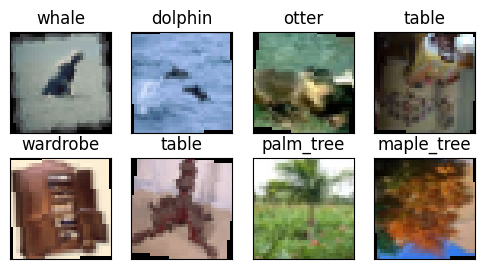

In [28]:
#Observe the dataset
print("Visualization of a sample of the dataset :")
show_img(trainset,train_data, random = True)

Visualization of random transformation on an image


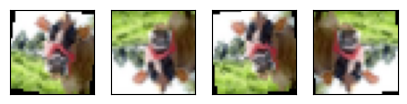

In [29]:
#Observe random transformation :
print("Visualization of random transformation on an image")
transform_visualisation(train_data)

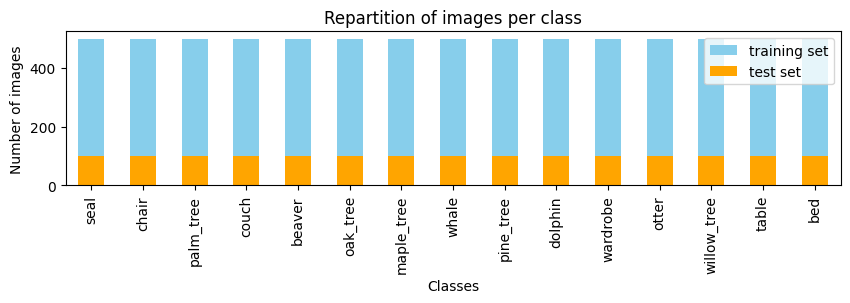

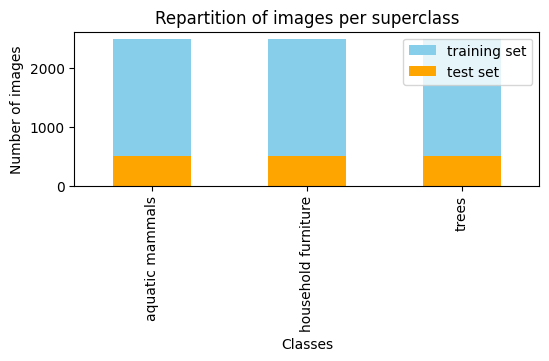

In [30]:
#Histogram repartion per class
plt.figure(figsize=(10, 2))
histogram_data_df("class",train_df,test_df)
#Histogram repartition per superclass
plt.figure(figsize=(6, 2))
histogram_data_df("superclass",train_df,test_df)

# 2. Training models :

## A. Classification in super-classes :

### a. Define models :

In [85]:
'''
#model pre-trained
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
'''

"\n#model pre-trained\nimport torch\nmodel = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)\n"

In [205]:
#Model create layer by layer
class convnet_no_dropout(nn.Module):
    # Constructor
    def __init__(self,nb_class):
        super(convnet_no_dropout, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding)
        '''
        self.nb_class = nb_class

        self.conv_layer_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 206)
        self.output_layer = nn.Linear(206, self.nb_class)

        #Dropout to avoid over-fitting :
        self.dropout_layer = nn.Dropout(p=0.5)

    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)

        # Flattening
        output = output.view(-1, 128*2*2)

        # Call fully connected layer
        output = self.hidden_layer(output)
        #adding dropout to avoid over-fitting
        output = self.dropout_layer(output)


        output=self.output_layer(output)

        return output


In [208]:
model = convnet_no_dropout(nb_class = len(SUPER_CLASSES))
summary(model,(3,32,32)) #le deuxième paramètre et la taille de l'entrée




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                  [-1, 206]         105,678
          Dropout-14                  [

## B. Training:




In [174]:
def convert_labels(labels,eq_df,old_label,new_label):
  labels_list = labels.tolist()
  #new_labels = [label for label in labels_list]

  new_labels = [eq_df[eq_df[old_label]== label_nb][new_label].values[0] for label_nb in labels_list]
  new_labels_tensor = torch.tensor(new_labels)
  return new_labels_tensor

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

def accuracy_B(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    #convert label to superclasses
    preds_B = convert_labels(preds,eq_df,old_label = "label_B",new_label = "label_A") # Convert from label at the class, and label at the superclass.
    labels_B = convert_labels(labels,eq_df,old_label = "label_B",new_label = "label_A")
    return torch.tensor(torch.sum(preds_B == labels_B).item()/len(preds))

def evaluate(model,valid_dl,loss_func,mode = "A"):
    model.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}")
        predicted=model(images)
        batch_losses.append(loss_func(predicted,labels))
        if mode == "A":
          batch_accs.append(accuracy(predicted,labels))
        elif mode == "B":
          batch_accs.append(accuracy_B(predicted,labels))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()# To keep only the mean
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim,eq_df,mode="A", scheduler_lr = "True"):

    #Choice of the optimization function, Weight decay is associated to L2 Norm
    if optim == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), max_lr,weight_decay=1e-5)
    elif optim == "SGD":
      optimizer= torch.optim.SGD(model.parameters(), max_lr,weight_decay=1e-4)
    elif optim == "Momentum":
      optimizer=torch.optim.SGD(model.parameters(), max_lr,momentum=0.9,weight_decay=1e-4)

    #Adding a learning rate scheduler
    if scheduler_lr :
      scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl)) #Allow a moving lr, best for fast convergence.


    results=[]
    best_epoch, best_epoch_nb = -1,-1 #To save the best epoch weight.
    for epoch in range(1,epochs+1):
        model.train()
        train_losses, train_batch_accs, lrs =[],[],[]

        #Compute over a minibatch
        for images, labels in train_dl:
          labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}") # Adapt to the classes (Option A or B)
          optimizer.zero_grad() #Gradient set to zero to avoid accumulation during training (Backprog at the scale of mini-batch not over all the dataset)
          predicted=model(images)
          loss=loss_func(predicted,labels)
          train_losses.append(loss)
          loss.backward() #Compute backpropagation
          optimizer.step() # Update weights

          # keep track of learning rate and metrics (here as the dataset is balanced, accuracy alone is relevant)
          if mode == "A":
            train_batch_accs.append(accuracy(predicted,labels))
          elif mode == "B":
            train_batch_accs.append(accuracy_B(predicted,labels)) #For Option B, the classification is made on classes, but the accuracy compute according superclasses.
          lrs.append(optimizer.param_groups[0]['lr'])
          if scheduler_lr :
            scheduler.step() #Update learning rate


        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model,valid_dl,loss_func,mode=mode) #having the avg metrics for the epoch.

        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})

        print('Number of epochs:', epoch,'|',
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
        #Save the best model
        if best_epoch == -1 or epoch_avg_acc > best_epoch:
          best_epoch = epoch_avg_acc
          torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')
          #remove old weight
          if best_epoch_nb != -1:
            os.remove(f'model_{mode}_optim_{optim}_epoch_{best_epoch_nb}_weights.pth')

          best_epoch_nb = epoch
        #Save the last epoch weight
        torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')
    #Save the last epoch weight
    torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')

    return results

#Visualization:
def plot_metric(train_metric,test_metric,label):
  plt.title(f"{label} per epoch")
  plt.plot(epoch_count,train_metric,label=f"Training {label}",linewidth = '1',color = "skyblue")
  plt.plot(epoch_count,test_metric,label=f"Test {label}",linewidth = '1',color = "orange")
  plt.xlabel('Epoch')
  plt.ylabel(f'{label} per epoch')
  plt.legend()


#Test functions.
def test_accuracy(mode = "A"):
  if mode == "A" :
    preds = [[0.3,-0.1,-0.1],[0.3,0.1,-0.1],[-0.3,0.1,-0.1]]
    labels = [0,1,1]
  else :
    preds = [[0,0,0,0.6,0,0,0.5,0,0,0,0,0.2,0,0,0],[0,0.7,0,0.6,0,0,0.5,0,0,0,0,0.2,0,0,0],[0,0,0,0.6,0,0,0.5,0,0,0,0.8,0.2,0,0,0]] # 4,2, 11
  preds = torch.tensor(preds)
  labels = torch.tensor(labels)
  if mode == "A":
    acc = accuracy(preds,labels)
  else :
    acc = accuracy_B(preds,labels)
  return acc


In [189]:
#TRAINING Options
#Parameters
OPTION = "A" #A (Classification per superclass) or B (Classification per class and accuracy per superclass)
EPOCHS = 5
BATCH_SIZE = 16

MAX_LR = 1e-4 #Best 1e-1/2 with scheduler or 1e-4 without
SCHEDULER = False
optim = "Adam" #Adam, SGD or Momentum

FROM_CKP = False #If loading from another model.
CKP_PATH = ""

#nb of classes for th model
if OPTION == "A":
  nb_class = len(SUPER_CLASSES)
elif OPTION == "B":
  nb_class = len(train_df["class"].unique())

#loading model
model = convnet_no_dropout(nb_class = nb_class)
if FROM_CKP:
  model.load_state_dict(torch.load(CKP_PATH))



#Loss
loss_func=nn.functional.cross_entropy # example : nn.functional.cross_entropy

#creating dataloader (for minibatch generation)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

#Launch training
results= train(model,trainloader,testloader,EPOCHS, MAX_LR, loss_func,optim,eq_df,mode=OPTION, scheduler_lr = SCHEDULER)

Number of epochs: 1 | Validation loss : 0.7802528738975525  | Training loss : 0.9222361445426941  |   Training accuracy: 0.5505952835083008 validation accuracy : 0.6593528389930725
Number of epochs: 2 | Validation loss : 0.6279895305633545  | Training loss : 0.6988598704338074  |   Training accuracy: 0.6992270946502686 validation accuracy : 0.7291666269302368
Number of epochs: 3 | Validation loss : 0.5549485087394714  | Training loss : 0.600112795829773  |   Training accuracy: 0.7488895058631897 validation accuracy : 0.7717198133468628
Number of epochs: 4 | Validation loss : 0.5050413012504578  | Training loss : 0.5543476939201355  |   Training accuracy: 0.7783848643302917 validation accuracy : 0.7958776354789734
Number of epochs: 5 | Validation loss : 0.47981685400009155  | Training loss : 0.5059950351715088  |   Training accuracy: 0.7957978248596191 validation accuracy : 0.8093971610069275


In [190]:
#Getting Metrics
avg_training_accuracy, avg_validation_accuracy =[], []
avg_training_loss, avg_validation_loss=[],[]
lr = []
for result in results:
    avg_training_accuracy.append(result['avg_train_acc'])
    avg_validation_accuracy.append(result['avg_val_acc'])
    avg_validation_loss.append(result['avg_valid_loss'])
    avg_training_loss.append(result['avg_train_loss'])
    lr = np.concatenate((lr,result['lrs']))
epoch_count=[]
for i in range(1,EPOCHS+1):
    epoch_count.append(i)

Text(0, 0.5, 'Learning rate')

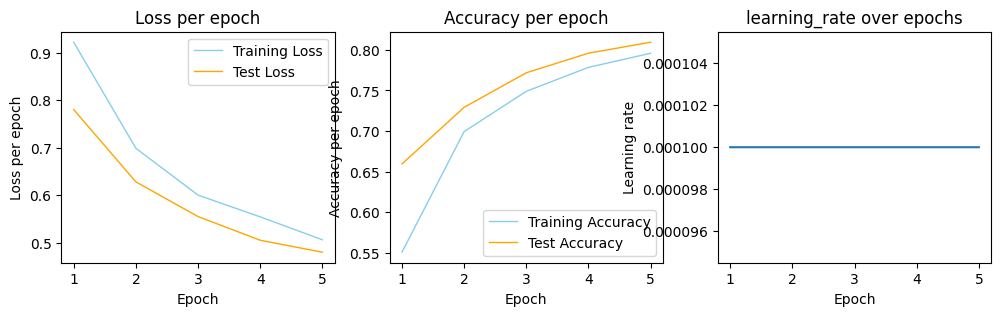

In [191]:
#Visualize metrics over epochs
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plot_metric(avg_training_loss,avg_validation_loss,"Loss")
plt.subplot(1,3,2)
plot_metric(avg_training_accuracy,avg_validation_accuracy,"Accuracy")

#Visualize lr evolution
plt.subplot(1,3,3)
epoch = np.linspace(1,EPOCHS,len(lr))
plt.plot(epoch,lr)
plt.title("learning_rate over epochs")
plt.xlabel('Epoch')
plt.ylabel('Learning rate')





#. Evaluate models:

In [158]:
#Functions :
def predict_img(img,model,mode = "A"):
  yb = model(img)
  _, pred = torch.max(yb, dim=1)
  if mode == "A":
    pred = pred.item()
  elif mode == "B":
    pred = convert_labels(pred,eq_df,old_label="label_B",new_label="label_A")
    pred = pred.item()
  return pred

def predict_and_show(img,label,model,mode = "A"):
  pred = predict_img(img,model,mode=mode)
  #Getting Super Class name from ground truth and prediction
  pred_sc = eq_df[eq_df[f"label_{mode}"]==pred]["superclass"].values[0]
  label_sc = eq_df[eq_df["label"]==label]["superclass"].values[0]
  img=img*0.5 +0.5 #Denormalize the img
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"gt: {label_sc}, pred :{pred_sc} ")
  return pred

In [160]:
#On charge les poids du modèle.
OPTION_eval = "A"
model_eval = convnet_no_dropout(nb_class=nb_class)
model_eval.load_state_dict(torch.load('/content/model_A_optim_Adam_epoch_15_weights.pth'))

<All keys matched successfully>

In [161]:
#Eval the model on the test dataset (Metrics + Confusion Matrix)
model_eval.eval()
batch_losses, batch_accs=[],[]
all_predictions, all_labels = [], []  # Pour la matrice de confusion
i=0

for images,labels in testloader:
  labels = convert_labels(labels,eq_df,old_label="label",new_label=f"label_{OPTION_eval}")
  predicted=model_eval(images)
  batch_losses.append(loss_func(predicted,labels))
  if OPTION_eval == "A":
    batch_accs.append(accuracy(predicted,labels))
  elif OPTION_eval == "B":
    batch_accs.append(accuracy_B(predicted,labels))

  # Collecter pour matrice de confusion
  _, preds = torch.max(predicted, 1)  # Classes prédites
  if OPTION_eval =="B":
    preds = convert_labels(preds,eq_df,old_label="label_B",new_label="label_A")
    labels = convert_labels(labels,eq_df,old_label="label_B",new_label="label_A")
  all_predictions.extend(preds.cpu().numpy())
  all_labels.extend(labels.cpu().numpy())

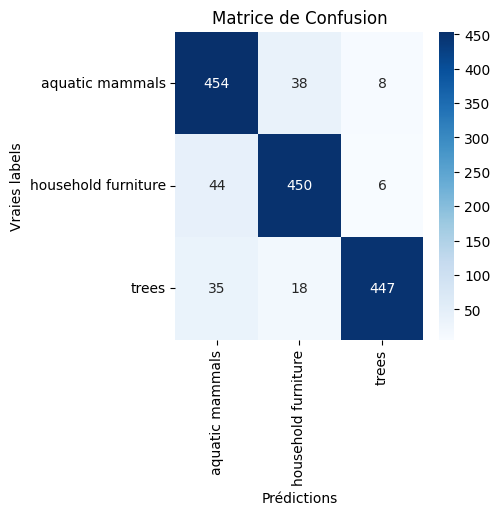

In [209]:
from sklearn.metrics import confusion_matrix, classification_report
# Créer la matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
#print(classification_report(all_labels, all_predictions))

# Plot de la matrice de confusion
class_names = SUPER_CLASSES
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraies labels')
plt.xlabel('Prédictions')
plt.show()

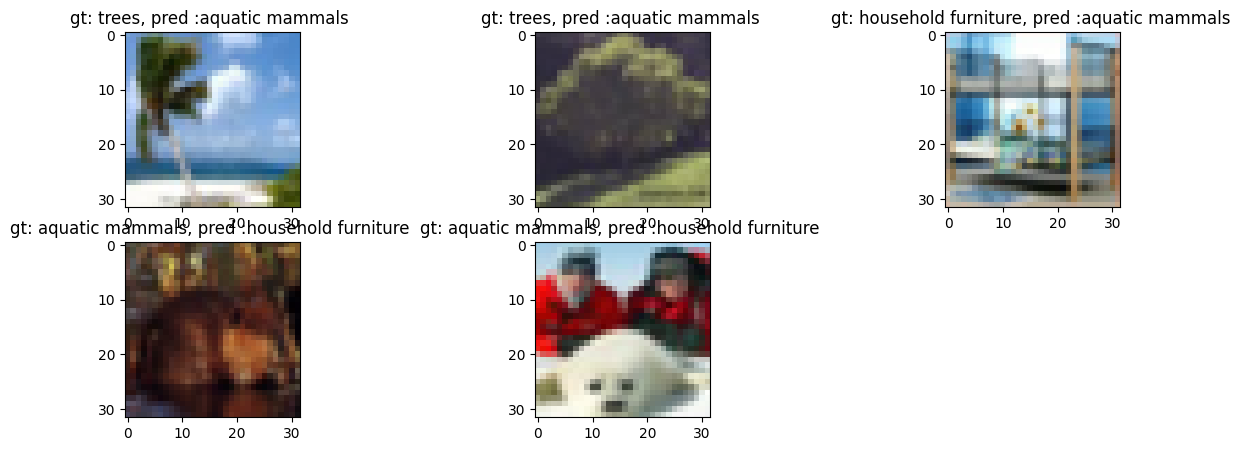

In [210]:
#List all wrong predictions
check_predict = np.equal(all_predictions,all_labels)
idx_false = np.where(check_predict == False)[0]

plt.figure(figsize=(15,5))
for i in range(5):

  #Observe some wrong predictions.
  idx_wrong = np.random.choice(idx_false)
  img,label = testset[idx_wrong]
  plt.subplot(2,3,i+1)
  pred = predict_and_show(img,label,model_eval)